# DeepCube Earth System Data Cube functionalities 
This notebook is a demonstration of some functionalities of the Earth System Data Cube technology  developed in the context of Horizon2020 project DeepCube and prepared for the final review meeting.

The tools are developed in [Julia](https://julialang.org/), a high-performance and versatile scientific programming language. This Jupyter notebook must hence be run with a Julia kernel, preferably with Julia 1.10.0.

In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/BGI/DeepCube/FinalESDCdemo`


When running the notebook for the first time, after activating the environment in the cell above, the cell below needs to be run to instantiate the aforementioned environment in order to install all required packages and their dependencies.

In [ ]:
using Pkg; Pkg.instantiate()

The packages can then be loaded.

In [2]:
using CairoMakie, Makie, GeoMakie
using YAXArrays, Zarr
using OnlineStats: Mean, value, fit!, nobs
using YAXArrays.Cubes: cubesize, formatbytes
using PerceptualColourMaps
import HDF5

## Access data cube

For this demo, we rely on [mesogeos](https://zenodo.org/records/7741518), a Mediterranean data cube for the modelling & analysis of wildfires developed in DeepCube for Use Case 3: Fire hazard short-term forecasting in the Mediterranean. It is stored on a publicly accessible s3 bucket hosted on OVH data store.

In [5]:
ENV["https_proxy"]="http://proxy1.bgc-jena.mpg.de:3128"


In [3]:
ds = open_dataset("https://my-uc3-bucket.s3.gra.io.cloud.ovh.net/mesogeos.zarr");

In [4]:
# show variables names
 print(keys(ds.cubes))

[:lst_night, :dem, :ignition_points, :lc_shrubland, :lc_forest, :lst_day, :d2m, :rh, :t2m, :wind_direction, :ndvi, :lc_water_bodies, :aspect, :lc_grassland, :ssrd, :burned_areas, :roads_distance, :lc_agriculture, :lai, :smi, :slope, :lc_settlement, :sp, :curvature, :spatial_ref, :lc_wetland, :population, :tp, :wind_speed, :lc_sparse_vegetation]

The dataset contains 30 variables, which all have dimensions x (longitude) and y (latitude). Most of them also have a time dimension.

We select one variable, `burned_areas`, to get information on the size of the cube and its chunking, that is, the way it is stored in compressed files.

In [5]:
# get dimensions
println("Data cube size: $(size(ds.burned_areas))")
# get chunks
println("Number of chunks: $(size(ds.burned_areas.chunks))")

Data cube size: (4714, 1752, 6026)
Number of chunks: (1, 1, 6026)


The dataset is chunked in a way most adapted for spatial analyses: each chunk contains data from one variable over its full spatial extent and only one time step. It is for example ideal to create maps for one single date as shown in the example below.


In [6]:
# coastlines
fid = HDF5.h5open("world_xm.h5", "r")
tmp = HDF5.read(fid["world_10m"])
x1 = tmp["lon"];
y1 = tmp["lat"];

# ndvi at four contrasting seasons
date = "2021-07-15"
ndvi = ds[:ndvi][time = At(Date(date))]
lon = lookup(ndvi, :x)
lat = lookup(ndvi, :y)
data = ndvi.data[:,:]
units = ("NDVI");

# colormap
colormap_ndvi = resample_cmap(:YlGn_9,256);


In [7]:
fig = Figure(;size=(1200,600));
ax = GeoAxis(fig[1,1], limits=(extrema(lon), extrema(lat)), title = date)
s = surface!(ax, lon, lat, data[:,:]; 
    colorrange=(0,1),
    lowclip=:lightblue,
    colormap = colormap_ndvi, 
    nan_color=:grey80,
    shading=NoShading,
)
# coastlines
cl=lines!(ax, 
    x1,y1,
    color = :black, linewidth=0.85)
translate!(cl, 0, 0, 1000)
# remove gridlines
ax.xgridcolor[] = colorant"transparent";
ax.ygridcolor[] = colorant"transparent";
ax.xticklabelsvisible = false;
ax.yticklabelsvisible = false;
# add colorbar
Colorbar(fig[1,2], s, label = units);
# save Figure
if !isdir("./figs")
    mkdir("./figs")
end
save("./figs/input_ndvi.png", fig)


Colorbar()

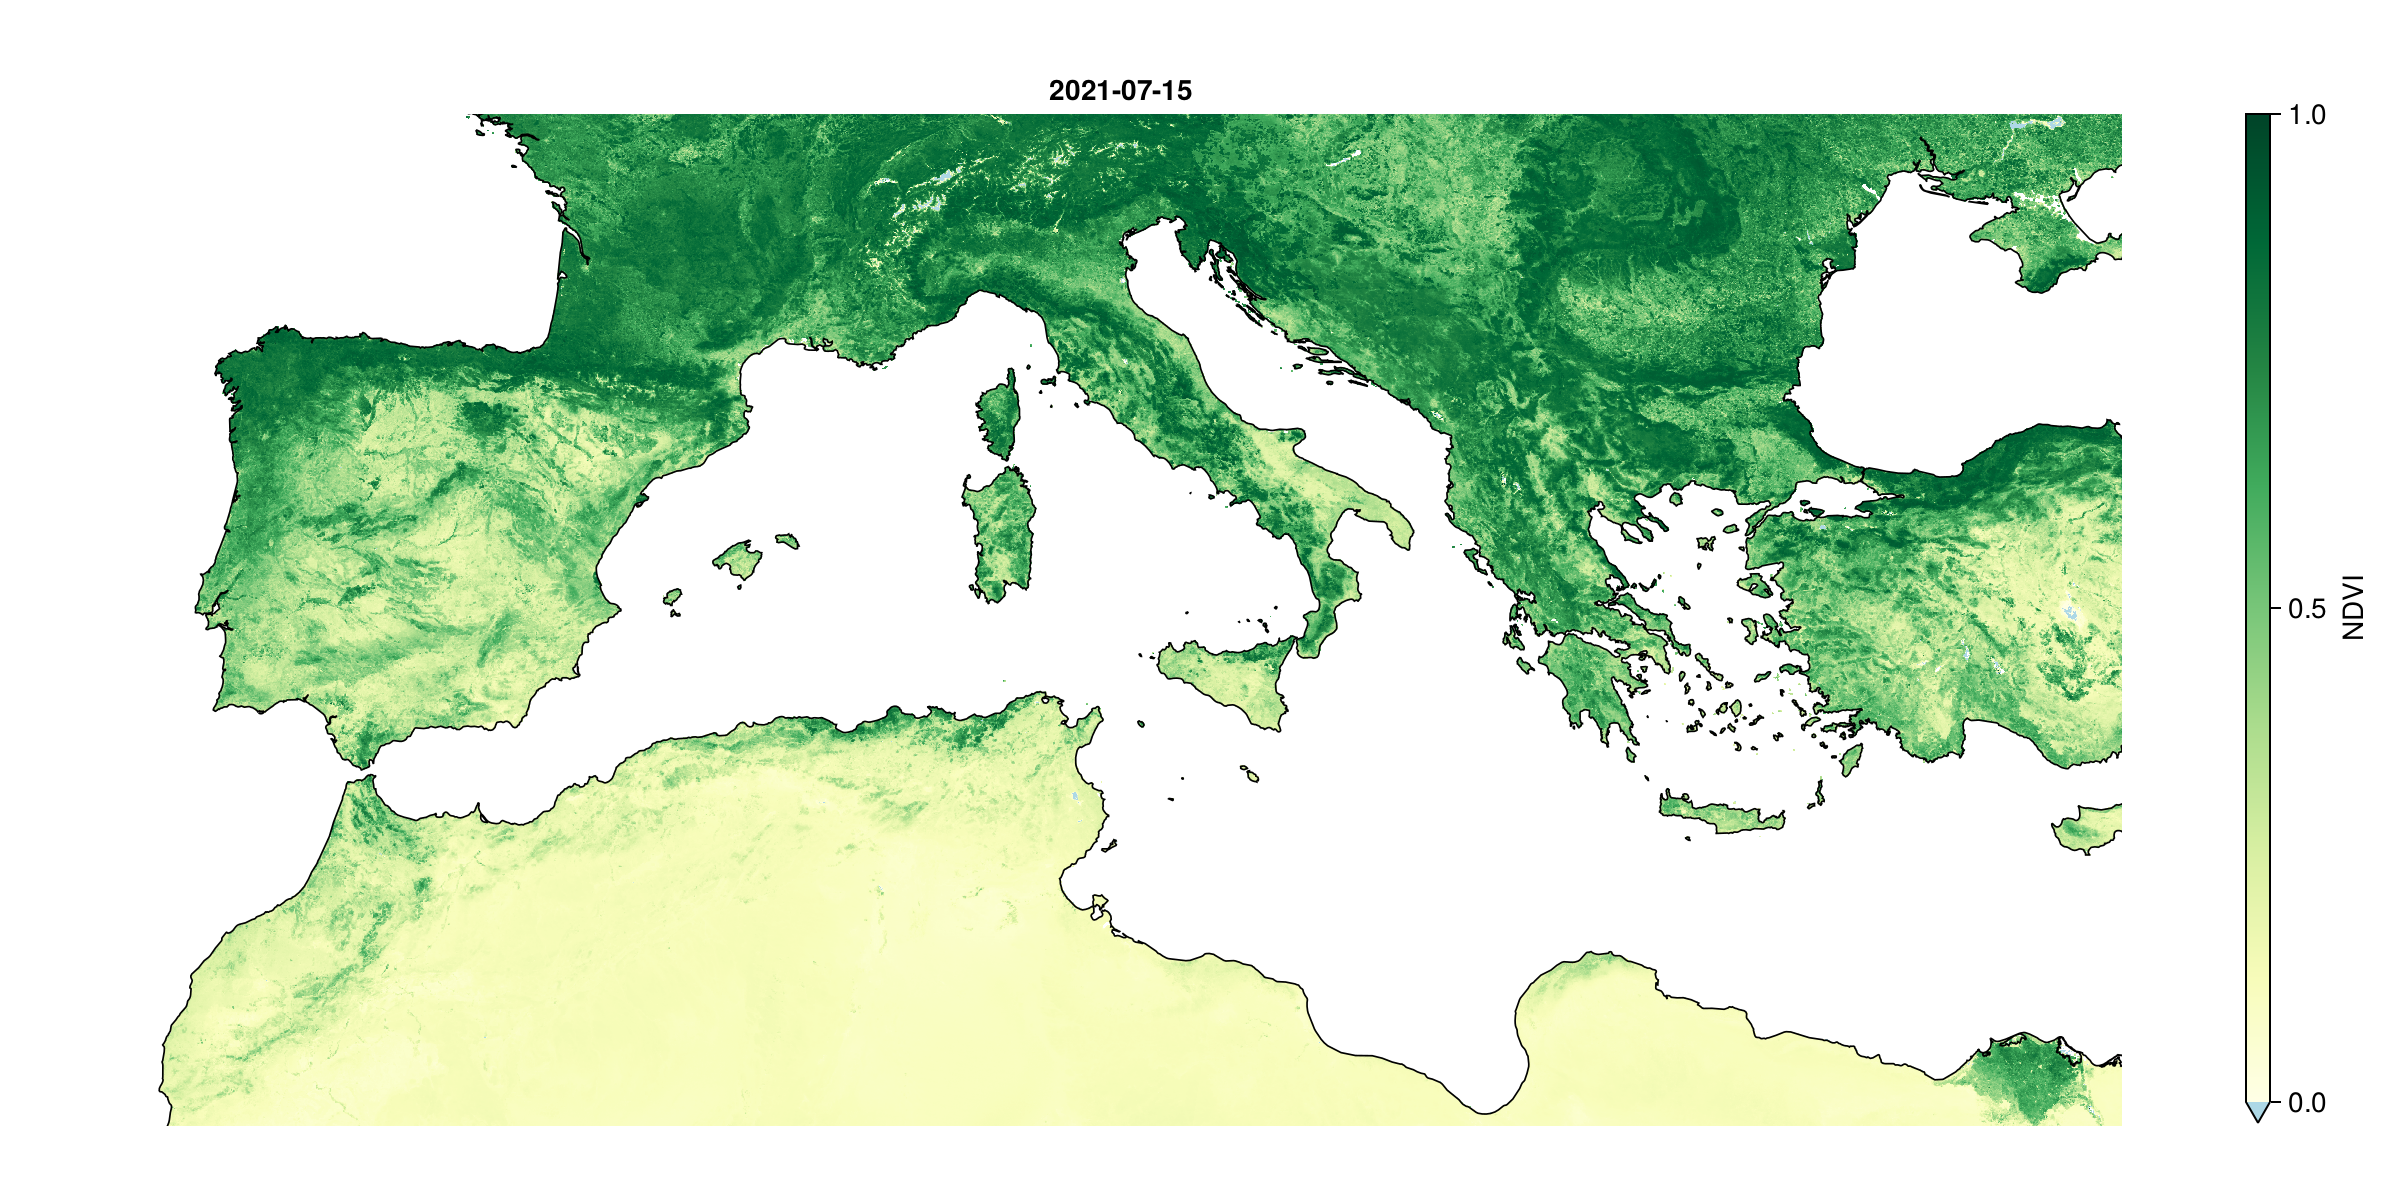

In [8]:
fig

If we want to analyses more than one time step at a time, we have to load into memory as many chunks as time steps we want to analyse simultaneously. Even if our analysis focuses on a small spatial area, we have to load the full spatial extent into memory.

Hence, for temporal analyses, it is more advisable to rechunk the dataset to chunks with a smaller spatial extent but with more time steps. 

## Rechunking

The rechunking requires to first download the full dataset. It can then be done with YAXArrays.jl in two lines of code as shown below.

In [8]:
# # DO NOT RUN
# dssub = ds[[:burned_areas,:net_ecosystem_exchange,:leaf_area_index]]

# dschunked = setchunks(dssub,target_chunks)

# savedataset(dschunked,path = "/Net/Groups/BGI/work_3/scratch/fgans/DeepCube/UC3Cube_rechunked2.zarr", max_cache=1e9, backend = :zarr,overwrite = false)
# # max_cache determines the amount of memory to be used for rechunking, the larger this is, the faster the rechunking will go
# # backend can be either :zarr or :netcdf
# # setting overwrite=true will delete any existing dataset
# # setting append=true will append the newly chunked variables to an existing data cube


Once the dataset has been rechunked to serve our purpose, we can access it and perform our temporal analysis.

## Temporal analysis

Our demo aims to analyse to which extent the mean of a selection of variables are different inside and outside burnt areas. Therefore, we compute the difference between a variable mean over time and over a spatial moving window `(7, 7)` inside burnt areas and in their direct surroundings, that is, outside the burnt area but within the spatial window and over the duration of the fire event. Since most areas are never burnt, we do not need to compute the means at every location, but only where there was a fire. Hence, we first identify "blobs" of contiguous burnt areas in these spatial windows and process them one at a time. That is, we load in memory just the chunks intersecting the spatial window and the timesteps at which the area was burnt.

<img src="figs/plot_event.png" alt="plot_event" width="800"/>

In [9]:
# Open the time series cube
ds = open_dataset("/Net/Groups/BGI/work_3/scratch/fgans/DeepCube/UC3Cube_rechunked2.zarr");

We select six variables as potential predictors for our analysis of burnt areas: night and land surface temperature, elevation, forest and grass cover fractions and distance to nearest road.

The total size of our uncompressed subdataset amounts to almost 1TB.

In [10]:
# Select variables of interest
burned_area = ds.burned_areas;
preds = ("lst_night", "lst_day","dem", "lc_forest", "lc_grassland", "roads_distance")
possible_predictors = map(i->ds[Symbol(i)],preds);

# Total uncompressed data size:
formatbytes(sum(cubesize,(burned_area,possible_predictors...)))

"927.07 GB"

In the following code lines, we define the dimensions over which we are going to run our analysis, that is, a `(7, 7, 6026)` moving window centred on our output grid cell, for our target and predictor variables (unless the latter does not have a time dimension). The output dimensions are defined as the predictor variables. Because we used `MovingWindow` in the input dimensions, the output will have `"x"` and `"y"` dimensions as the input dataset.

In [11]:
indims_burnedarea = InDims(MovingWindow("x",3,3), MovingWindow("y",3,3), "Time", window_oob_value = 0.f0)
indims_predictors = map(possible_predictors) do p
    td = ndims(p) == 3 ? ("Time",) : ()
    InDims(MovingWindow("x",3,3), MovingWindow("y",3,3), td..., window_oob_value = 0.f0)
end

outdims = OutDims(
    Dim{:Variable}(collect(preds)), 
    outtype = Float32, 
    backend=:zarr,
    path = "./output.zarr", 
    overwrite=true
)


OutDims((YAXArrays.ByValue(Dim{:Variable, Vector{String}}(["lst_night", "lst_day", "dem", "lc_forest", "lc_grassland", "roads_distance"])),), :zarr, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol}, @NamedTuple{path::String, overwrite::Bool}}(:path => "./output.zarr", :overwrite => true), false, Array, :input, Float32)

We set up the job to be run on the cluster. The analysis is run on the MPI-BGC cluster but could be run on any cloud computing facility supporting Julia or docker containers.

Therefore, we load two new Julia packages: `SlurmManager` to interact with the Slurm cluster and `Distributed`, which supports distributed computing. For some reason, on our partition for big data, the workers need to be spawned one at a time.

In [12]:
n_workers = 20
threads_per_worker = 16
#Get 20 workers with 32 cpus per worker
using ClusterManagers: SlurmManager
using Distributed
addprocs(
    SlurmManager(n_workers),
    partition="big",
    mem_per_cpu="16GB",
    time="00:30:00",
    cpus_per_task=threads_per_worker,
    exeflags=`--project=$(@__DIR__) -t $threads_per_worker --heap-size-hint=8GB`
);

connecting to worker 1 out of 20
connecting to worker 2 out of 20
connecting to worker 3 out of 20
connecting to worker 4 out of 20
connecting to worker 5 out of 20
connecting to worker 6 out of 20
connecting to worker 7 out of 20
connecting to worker 8 out of 20
connecting to worker 9 out of 20
connecting to worker 10 out of 20
connecting to worker 11 out of 20
connecting to worker 12 out of 20
connecting to worker 13 out of 20
connecting to worker 14 out of 20
connecting to worker 15 out of 20
connecting to worker 16 out of 20
connecting to worker 17 out of 20
connecting to worker 18 out of 20
connecting to worker 19 out of 20
connecting to worker 20 out of 20


Once the workers are spawned, we load the required packages and functions on all of them. [windowfire.jl](windowfire.jl) is the script that contains the functions `fire_boundaries_window!` and `process_event`, which are at the core of our analysis.

In [13]:
# Load code everywhere
@everywhere begin
    using YAXArrays, Zarr
    using OnlineStats: Mean, value, fit!, nobs
    include("windowfire.jl")
    Zarr.Blosc.set_num_threads($threads_per_worker)
end

The `fire_boundaries_window!` function is applied in parallel on the moving windows thanks to the `YAXArrays` function `mapCube`.

In [14]:
@time mapCube(
    fire_boundaries_window!, 
    (burned_area, possible_predictors...);
    indims = (indims_burnedarea, indims_predictors...), 
    outdims = outdims,
    max_cache=1e9,
)

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:03

479.528242 seconds (23.81 M allocations: 2.600 GiB, 0.41% gc time, 3.34% compilation time)


4714×1752×6 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:x} Sampled{Float64} -10.719097328696062:0.010068971773281372:36.73596663877905 ForwardOrdered Regular Points,
  Dim{:y} Sampled{Float64} 47.69923994531206:-0.01006897177328137:30.068470370296378 ReverseOrdered Regular Points,
  Dim{:Variable} Categorical{String} String[lst_night, lst_day, …, lc_grassland, roads_distance] Unordered
Total size: 189.03 MB


Once the above code has been executed, the workers can be closed and the results can be plotted.

In [15]:
rmprocs(workers());

## Visualisation

The output data cube contains the differences between the averages inside and outside burnt areas in the direct surrounding (`(7, 7)` window) for the six possible predictor variables. It has no time dimension, only x and y.

We can create maps of the output after loading plotting packages.

In [2]:
using CairoMakie, Makie, GeoMakie, PerceptualColourMaps
using YAXArrays, Zarr
using Statistics
using HDF5

In [5]:
if !isdir("./figs")
    mkdir("./figs")
end

# output of moving windo demo
ds = YAXArrays.open_dataset("/Net/Groups/BGI/people/fgans/DeepCube/FinalESDCdemo/output.zarr/")

preds = ("lst_night", "lst_day","dem", "lc_forest", "lc_grassland", "roads_distance")
possible_predictors = map(i->ds[Symbol(i)],preds);

# units of the predictors, used in the legend of the maps
units = ("Temperature [Kelvin]","Temperature [Kelvin]","Elevation [m]", "Forest cover [%]", "Grass cover [%]", "Distance to nearest road [km]")

# coastlines
fid = h5open("world_xm.h5", "r")
tmp = read(fid["world_10m"])
x1 = tmp["lon"];
y1 = tmp["lat"];

# colormap
n = 128
colormap = vcat(resample_cmap(:linear_kbc_5_95_c73_n256, n),
    resample_cmap(Reverse(:linear_kryw_5_100_c67_n256), n))


function myfig!(fig, lon, lat, data, q, units)
    ax = GeoAxis(fig[1,1], limits=(extrema(lon), extrema(lat)))
    s = surface!(ax, lon, lat, data; 
        colorrange=(-maximum(abs.(q)), maximum(abs.(q))),
        highclip=:black,
        lowclip=:grey8,
        #colorscale = sc,
        colormap, nan_color=:grey80,
        shading=NoShading,
    )
    # coastlines
    cl=lines!(ax, 
        # GeoMakie.coastlines(),
        x1,y1,
        color = :black, linewidth=0.85)
    translate!(cl, 0, 0, 1000)
    Colorbar(fig[1,2], s, label = units)
    # remove gridlines
    ax.xgridcolor[] = colorant"transparent";
    ax.ygridcolor[] = colorant"transparent";
    ax.xticklabelsvisible = false;
    ax.yticklabelsvisible = false;
    return(fig)
end

myfig! (generic function with 1 method)

In [6]:
for i in 1:(length(possible_predictors))
    fig = Figure(;size=(1200,600));
    c = possible_predictors[i]
    lon = lookup(c, :x)
    lat = lookup(c, :y)
    data = c.data[:,:];

    @show q = Statistics.quantile(filter(i->!ismissing(i) && !isnan(i), data),(0.1,0.5,0.9))

    fig = myfig!(fig, lon, lat, data, q, units[i])
    Label(fig[1, 1:end, Top()], "Difference in average $(preds[i]) inside and outside burned areas", fontsize=18, padding=(0, 6, 8, 0))

    save("./figs/$(preds[i]).png", fig)


    # Distribution plot
    tmp = vec(filter(i->!ismissing(i) && !isnan(i), data));
    fig,ax, = violin(ones(size(tmp)...), tmp)
    ax.ylabel = units[i];
    ax.xgridcolor[] = colorant"transparent";
    ax.xticklabelsvisible = false;
    ax.xtickcolor[] = colorant"transparent";
    save("./figs/$(preds[i])_violin.png", fig)

    # zoom on map
    sc = c[x = 20.5 .. 23.5, y = 36 .. 38.5]
    slon = lookup(sc, :x)
    slat = lookup(sc, :y)
    sdata = sc.data[:,:];
    fig = Figure(;size=(500,500));
    fig = myfig!(fig, slon, slat, sdata, q, units[i])
    Label(fig[1, 1:end, Top()], "Difference in average $(preds[i]) inside and outside burned areas", fontsize=12, padding=(0, 6, 8, 0))
    save("./figs/$(preds[i])_zoom.png", fig)

end


q = Statistics.quantile(filter((i->begin
                    #= In[6]:8 =#
                    !(ismissing(i)) && !(isnan(i))
                end), data), (0.1, 0.5, 0.9)) = (-1.267620551586151, 0.06263842806220055, 1.503210043907166)
q = Statistics.quantile(filter((i->begin
                    #= In[6]:8 =#
                    !(ismissing(i)) && !(isnan(i))
                end), data), (0.1, 0.5, 0.9)) = (-2.2361907958984375, -0.046473072841763496, 2.2471948862075806)
q = Statistics.quantile(filter((i->begin
                    #= In[6]:8 =#
                    !(ismissing(i)) && !(isnan(i))
                end), data), (0.1, 0.5, 0.9)) = (-86.05587768554688, 18.849763870239258, 175.43064575195314)
q = Statistics.quantile(filter((i->begin
                    #= In[6]:8 =#
                    !(ismissing(i)) && !(isnan(i))
                end), data), (0.1, 0.5, 0.9)) = (-0.16611215770244597, 0.007336815819144249, 0.3147680699825286)
q = Statistics.quantile(filter((i->begin
           

We can display the saved figures.

Distance to nearest road

<img src="figs/roads_distance.png" alt="roads_distance_full" width="800"/>
<p float="left">
<img src="figs/roads_distance_violin.png" alt="roads_distance_violin" width="350"/>
<img src="figs/roads_distance_zoom.png" alt="roads_distance_zoom" width="350"/>
</p>

Forest cover

<img src="figs/lc_forest.png" alt="lc_forest" width="800"/>
<p float="left">
<img src="figs/lc_forest_violin.png" alt="roads_distance_violin" width="350"/>
<img src="figs/lc_forest_zoom.png" alt="lc_forest_zoom" width="350"/>
</p>